In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from math import pi
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import curve_fit

import matplotlib.cm as cm

In [2]:
%matplotlib inline

In [3]:
font = {'family': 'serif', 'size': 12}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [4]:
cmap = plt.get_cmap("tab10")

# system info

In [5]:
kbK_2_ev = 0.00008661733
T = 300 #K

In [6]:
kbT = kbK_2_ev*T
sysname='s-10'
mol_list= [2,4,6,8]

# number of urea and water molecules, volume [A^3]
natom_dict={
2:[4928/8,46584/3, 5.10781090e+05],
4:[9856/8,42000/3, 5.09710418e+05],
6:[14784/8,37368/3, 5.09839805e+05],
8:[19712/8,32688/3, 5.08661907e+05]
}

name_dict={'CC':'urea-urea', 'CO':'urea-water','OO':'water-water'}

In [7]:
def fit_OrnsteinZernike(x, s0, xi):
    # S(k) = S(0)/(1+xi*k^2)
    return s0/(1.+xi*x**2.)

In [8]:
def ideal_mu(c, c0, kbt):
    return kbt*np.log(c/c0)

In [9]:
def get_activity_coefficient(saa,sab,nratio):
    return 1./(saa-sab*(nratio)**0.5)

In [10]:
# read reference

# R. H. Stokes, Aust. J. Chem. 20, 2087 (1967).
Exp1 = np.genfromtxt('./refs/Exp1.txt')

# O. Miyawaki, A. Saito, T. Matsuo, and K. Nakamura, Biosci. Biotechnol. Biochem. 61, 466–469 (1997).
Exp2 = np.genfromtxt('./refs/Exp2.txt')

# T. E. de Oliveira, P. A. Netz, K. Kremer, C. Junghans, and D. Mukherji, J. Chem. Phys. 144, 174106 (2016).
Oliveira2016 = np.genfromtxt('./refs/Oliveira-JCP-2016.txt')

CortesHuerto2016 = np.genfromtxt('./refs/Cortes-Huerto-JCP-2016.txt')

# Read in the values of S(k) at different k

In [11]:
Sk={}

for ii in ['CC', 'CO','OO']:
    Sk[ii] = {}
    
    for mol in mol_list:
        Sk[ii][mol] = np.loadtxt(str(mol)+"M/Sk-"+sysname+"-"+ii+"-real-avg.list", skiprows=0)[:,:]

In [12]:
Sk_fit={}
S0_list = {}

kcut = 0.01
for ii in ['CC', 'CO','OO']:
    Sk_fit[ii] = {}
    S0_list[ii] = []
    
    for mol in mol_list:
    
        Sk_cut = np.asarray([sk for sk in Sk[ii][mol][1:] if sk[0]**2.+sk[1]**2.+sk[2]**2. < kcut])
        ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in Sk_cut]
        sk_now = Sk_cut[:,3]
        sk_error_now = Sk_cut[:,5]

        #if np.isnan(Sk[ii][mol][2,3]): continue
        popt, pcov = curve_fit(fit_OrnsteinZernike, 
                           ksqr_now, 
                           sk_now, )
                           #sigma=sk_error_now,
                           #absolute_sigma=False)
        perr = np.sqrt(np.diag(pcov))
        #print(ii, mol,popt,perr)
        Sk_fit[ii][mol]={'value': popt, 'error': perr}
        # mol, S0, S0_error, Xi, Xi_error
        S0_list[ii].append([mol, popt[0], perr[0], popt[1], perr[1]])
    S0_list[ii] = np.asarray(S0_list[ii])

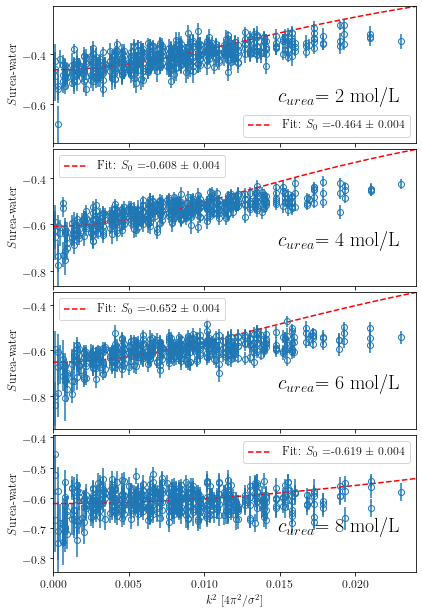

In [13]:
fig, ax = plt.subplots(4,1, sharex=True, sharey=False,figsize=(6.5,6.5*1.6))

krange = 0.001*np.arange(25)

ii = 'CO'

for i,mol in enumerate(mol_list):
    
    ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in Sk[ii][mol][1:]]
    sk_now = Sk[ii][mol][1:,3]
    sk_error_now = Sk[ii][mol][1:,5]
    popt = Sk_fit[ii][mol]['value']
    perr = Sk_fit[ii][mol]['error']
    
    ax[i].errorbar(ksqr_now, sk_now, sk_error_now,
             ls='',marker='o', markerfacecolor='None')


    ax[i].plot(krange, fit_OrnsteinZernike(krange, *popt), 'r--',
         label='Fit: $S_0~$=%5.3f $\pm$ %5.3f' % (popt[0],perr[0]))
    
    ax[i].text(0.62, 0.25, r'$c_{urea}$= '+str(mol)+" mol/L",
                 fontsize=20, transform=ax[i].transAxes,
                      verticalalignment='bottom')
    ax[i].legend()#loc='upper right')
    #ax[i].set_xlim([0,2.0])
    #ax[i].set_ylim([0.0,min(9,1+np.amax(wave_DT))])
    ax[i].margins(-0.0, x=None, y=None, tight=True)
    #ax[i].set_xlabel("$|k|$")    
    ax[i].set_ylabel("$S$"+name_dict[ii])
    
ax[-1].set_xlabel("$k^2$ [$4\pi^2$/$\sigma^2$]")    
#ax[0].set_ylabel("$\lambda$")
fig.subplots_adjust(hspace=0.05, wspace=0.02)
#fig.tight_layout()

fig.savefig("selected-k-S-"+sysname+".pdf", dpi=300, bbox_inches='tight')

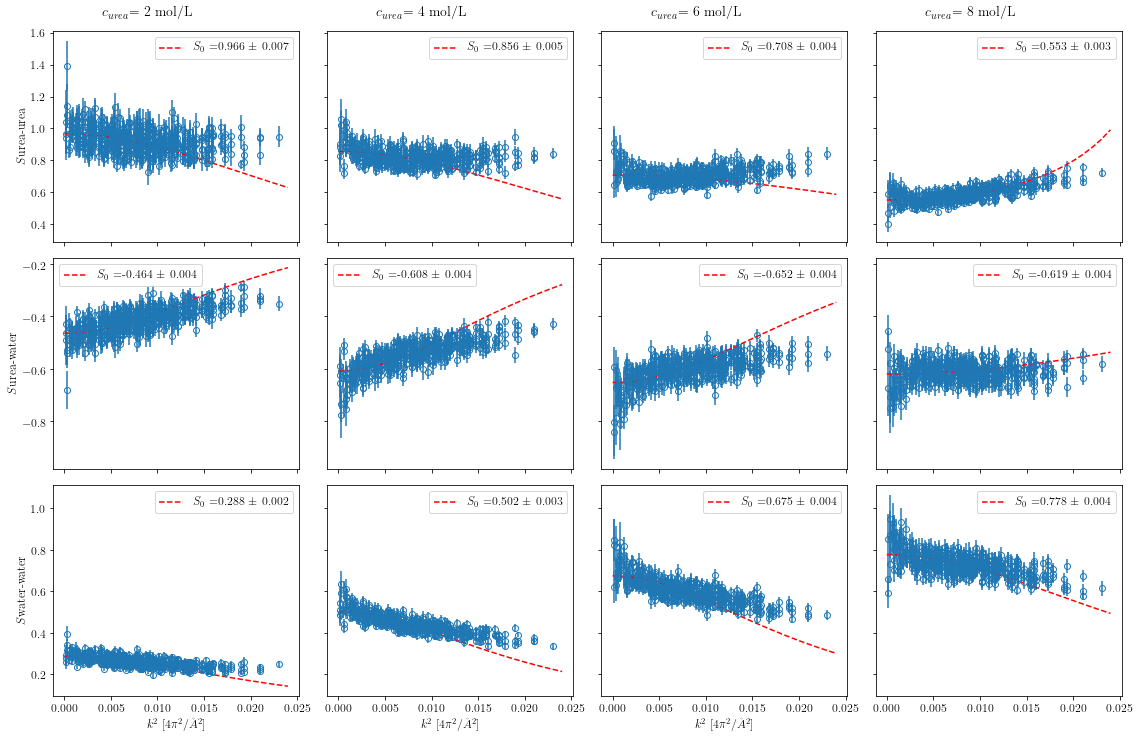

In [14]:
fig, ax = plt.subplots(3,len(mol_list), sharex=True, sharey='row',figsize=(16,6.5*1.6))

krange = 0.001*np.arange(25)

for i,ii in enumerate(['CC','CO','OO']):

    for j,mol in enumerate(mol_list):

        ksqr_now = [ sk[0]**2.+sk[1]**2.+sk[2]**2. for sk in Sk[ii][mol][1:]]
        sk_now = Sk[ii][mol][1:,3]
        sk_error_now = Sk[ii][mol][1:,5]
        popt = Sk_fit[ii][mol]['value']
        perr = Sk_fit[ii][mol]['error']

        ax[i,j].errorbar(ksqr_now, sk_now, sk_error_now,
                 ls='',marker='o', markerfacecolor='None')


        ax[i,j].plot(krange, fit_OrnsteinZernike(krange, *popt), 'r--',
             label='$S_0~$=%5.3f $\pm$ %5.3f' % (popt[0],perr[0]))

        
        ax[i,j].legend()#loc='upper right')
        #ax[i].set_xlim([0,2.0])
        #ax[i].set_ylim([0.0,min(9,1+np.amax(wave_DT))])
        #ax[i,j].margins(-0.0, x=None, y=None, tight=True)
        #ax[i].set_xlabel("$|k|$")    
        if j==0: ax[i,j].set_ylabel("$S$"+name_dict[ii])
        if i==0:
            ax[i,j].text(0.2, 1.05, r'$c_{urea}$= '+str(mol)+" mol/L",
                     fontsize=14, transform=ax[i,j].transAxes,
                          verticalalignment='bottom')
    
    ax[-1,i].set_xlabel("$k^2$ [$4\pi^2$/$\AA^2$]")    

#ax[0].set_ylabel("$\lambda$")
fig.subplots_adjust(hspace=0.05, wspace=0.02)
fig.tight_layout()

fig.savefig("urea-ll-k-S-"+sysname+".pdf", dpi=300, bbox_inches='tight')

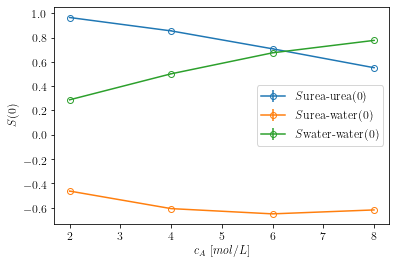

In [15]:
fig, ax = plt.subplots(figsize=(6,4))

for i,ii in enumerate(['CC', 'CO','OO']):
    ax.errorbar(S0_list[ii][:,0],S0_list[ii][:,1], S0_list[ii][:,2],
           ls='-',marker='o',markerfacecolor='None', c=cmap(i),
           label="$S$"+name_dict[ii]+"(0)")

ax.legend()
ax.set_ylabel("$S(0)$")
    
ax.set_xlabel("$c_A~[mol/L]$")  

fig.savefig("urea-S-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')

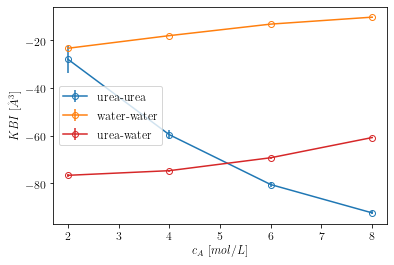

In [16]:
fig, ax = plt.subplots(figsize=(6,4))


ca_ratio_now = np.asarray([ natom_dict[mm][0]/natom_dict[mm][2] for mm in mol_list])
cb_ratio_now = np.asarray([ natom_dict[mm][1]/natom_dict[mm][2] for mm in mol_list])

ax.errorbar(S0_list['CC'][:,0],
                (S0_list['CC'][:,1]-1)/ca_ratio_now,  #(S0-1)/ca 
                S0_list['CC'][:,2]/ca_ratio_now,
           ls='-',marker='o',markerfacecolor='None', c=cmap(0),
           label=name_dict['CC'])

ax.errorbar(S0_list['OO'][:,0],
                (S0_list['OO'][:,1]-1)/cb_ratio_now,  #(S0-1)/ca 
                S0_list['OO'][:,2]/cb_ratio_now,
           ls='-',marker='o',markerfacecolor='None', c=cmap(1),
           label=name_dict['OO'])

ax.errorbar(S0_list['CO'][:,0],
                S0_list['CO'][:,1]/(ca_ratio_now*cb_ratio_now)**0.5,  #(S0)/sqrt(ca*cb) 
                S0_list['CO'][:,2]/(ca_ratio_now*cb_ratio_now)**0.5,
           ls='-',marker='o',markerfacecolor='None', c=cmap(3),
           label=name_dict['CO'])

ax.legend()
ax.set_ylabel("$KBI~[\AA^3]$")
# mol = 6.022 × 10²³
# A^3 = 602.2  cm^3/mol
#ax.set_ylim([-2,-0.93])
    
ax.set_xlabel("$c_A~[mol/L]$")  

fig.savefig("G-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')

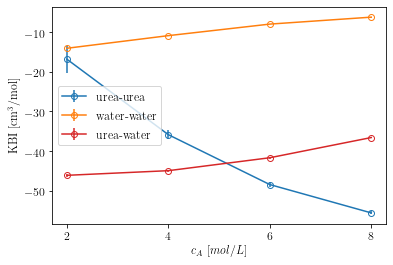

In [17]:
fig, ax = plt.subplots(figsize=(6,4))


ca_ratio_now = np.asarray([ natom_dict[mm][0]/natom_dict[mm][2] for mm in mol_list])
cb_ratio_now = np.asarray([ natom_dict[mm][1]/natom_dict[mm][2] for mm in mol_list])

ax.errorbar(S0_list['CC'][:,0],
               0.6022* (S0_list['CC'][:,1]-1)/ca_ratio_now,  #(S0-1)/ca 
               0.6022* S0_list['CC'][:,2]/ca_ratio_now,
           ls='-',marker='o',markerfacecolor='None', c=cmap(0),
           label=name_dict['CC'])

ax.errorbar(S0_list['OO'][:,0],
               0.6022* (S0_list['OO'][:,1]-1)/cb_ratio_now,  #(S0-1)/ca 
               0.6022* S0_list['OO'][:,2]/cb_ratio_now,
           ls='-',marker='o',markerfacecolor='None', c=cmap(1),
           label=name_dict['OO'])

ax.errorbar(S0_list['CO'][:,0],
                0.6022*S0_list['CO'][:,1]/(ca_ratio_now*cb_ratio_now)**0.5,  #(S0)/sqrt(ca*cb) 
                0.6022*S0_list['CO'][:,2]/(ca_ratio_now*cb_ratio_now)**0.5,
           ls='-',marker='o',markerfacecolor='None', c=cmap(3),
           label=name_dict['CO'])

ax.legend()
ax.set_ylabel("KBI [cm$^3$/mol]")
# mol = 6.022 × 10²³
# A^3 = 0.6022  cm^3/mol
#ax.set_ylim([-2,-0.93])
    
ax.set_xlabel("$c_A~[mol/L]$") 
ax.set_xticks(np.arange(2, 8.1, step=2))

fig.savefig("G-ca-"+sysname+"-si.pdf", dpi=300, bbox_inches='tight')

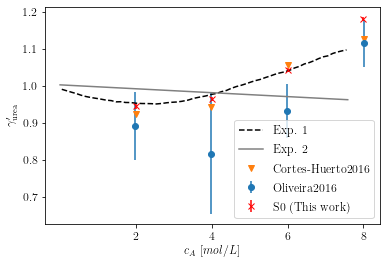

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

Exp1 = Exp1[Exp1[:, 0].argsort()]
ax.plot(Exp1[:,0],Exp1[:,1],label='Exp. 1',ls='--',c='k')
ax.plot(Exp2[:,0],Exp2[:,1],label='Exp. 2', ls='-',c='gray')

ax.errorbar(Oliveira2016[:,0],Oliveira2016[:,1],Oliveira2016[:,2], 
            ls='',marker='o',
            label='Oliveira2016')

ax.plot(CortesHuerto2016[:,0],CortesHuerto2016[:,1],
        ls='',marker='v',
        label='Cortes-Huerto2016')

c_ratio_now = np.asarray([ natom_dict[mm][0]/natom_dict[mm][1] for mm in mol_list])
ax.errorbar(S0_list['CC'][:,0],
        get_activity_coefficient(S0_list['CC'][:,1], S0_list['CO'][:,1], c_ratio_now),
        get_activity_coefficient(S0_list['CC'][:,1]+S0_list['CC'][:,2], S0_list['CO'][:,1]-S0_list['CO'][:,2], c_ratio_now)-
        get_activity_coefficient(S0_list['CC'][:,1], S0_list['CO'][:,1], c_ratio_now),
            c='r',
            ls='',marker='x',markerfacecolor='None',
           label='S0 (This work)')


ax.set_ylabel("$\gamma'_\mathrm{urea}$")
    
ax.set_xlabel("$c_A~[mol/L]$")  
ax.set_xticks(np.arange(2, 8.1, step=2))
ax.legend()

fig.savefig("gamma-ca-"+sysname+".pdf", dpi=300, bbox_inches='tight')